# Simulations with large ptychographic scan steps (ie sparse scans) and with low values for the scattering amplitudes (ie weak).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation, Simulation
from skimage.feature import register_translation
from skimage.restoration import unwrap_phase
from scipy import io
import copy
import os
import dill
import ast
import h5py

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base_path = os.environ['HOME']

In [4]:
base_path

'/home/skandel'

In [14]:
probe_2d = io.loadmat(f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/recon_probe_29902.mat')["prb"]
probes_3d_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes_4_peaks.mat'

In [15]:
probes_3d_h5_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes.h5'

In [17]:
hanning = np.hanning(probe_2d.shape[0])
probe_2d_hanning = probe_2d * (hanning * hanning[:,None])

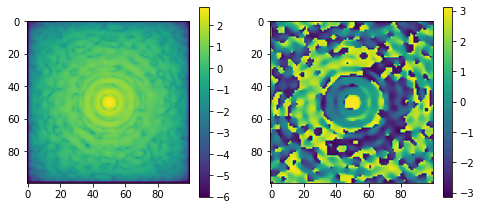

In [18]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d_hanning) + 1e-6))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [19]:
strain_type = 'two_edge_slip'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [20]:
hkl_list = np.array([[1, 0, 0], [1, 1, 0], [1, 2, 0], [2, 1, 0]])

In [21]:
if not os.path.isdir(data_path):
    raise Exception(f"Ensure the directory {data_path} exists")

In [22]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm = reloadSimulation(sim_data_path, reload_sim=True,
                      reload_sample_only_filename=sample_data_path,
                      save_sample_only_filename=sample_data_path,
                      new_sim_params={'poisson_noise':True, 
                                      'probes_matlab_h5_file':probes_3d_h5_path, 
                                      'n_scan_positions':9,
                                      'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 0, 0],
                                                           [1, 1, 0],
                                                           [1, 2, 0],
                                                           [2, 1, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004, 0.0035, 0.0021, 0.0015],#np.array([0.00107052, 0.000707052, 
                                                                    #          0.0005033028, 0.0003033028]),
                                     'poisson_noise': True},
                      new_extra_sample_params={'strain_type':strain_type, 
                                               'npix_delta_x':5,
                                               'npix_delta_y':5,
                                               'grain_width': 0.5,
                                               'grain_height': 0.45})

File does not exist. Creating new simulation...
Creating new simulation...
Reloading sample from provided file... /home/skandel/code/mbptycho/experiments/python/two_edge_slip_sparse/apodized_probe_weak_peaks/sample_two_edge_slip.pkl
Sample reloaded.
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from h5py file...
Loading successfull...
Adding poisson noise...
Adding poisson noise...
Adding poisson noise...
Adding poisson noise...
Saving new simulation at /home/skandel/code/mbptycho/experiments/python/two_edge_slip_sparse/apodized_probe_weak_peaks/sim_two_edge_slip.pkl...


In [23]:
for i in range(4):
    diffs = sm.simulations_per_peak[i].diffraction_patterns
    print(diffs.max(), diffs.sum(axis=(1,2)).max())

767 116316
594 74255
546 33650
120 16395


In [24]:
sm.simulations_per_peak[1].diffraction_patterns.shape

(81, 150, 150)

In [25]:
random_indices = np.random.randint(sm.simulations_per_peak[1].diffraction_patterns.shape[0], size=16).reshape(4,4)

In [26]:
random_indices

array([[23, 43, 76, 44],
       [74, 42, 61, 52],
       [72, 53, 45, 44],
       [19,  2, 27,  6]])

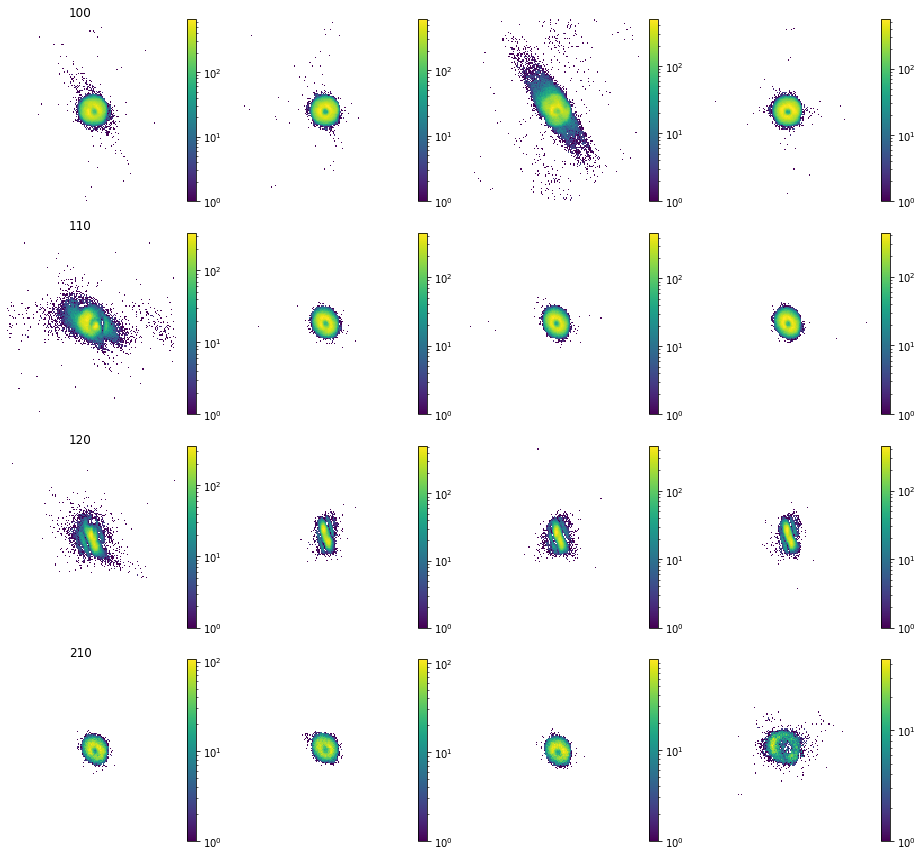

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(13, 12))
for i1 in range(4):
    for i2 in range(4):
        diff_this = sm.simulations_per_peak[i1].diffraction_patterns[random_indices[i1, i2]]
        plt.subplot(4, 4, i1 * 4 +  i2 + 1)
        plt.pcolormesh(np.fft.fftshift(diff_this), norm=mpl.colors.LogNorm())
        
        plt.colorbar()
        if i2 == 0: plt.title(''.join(sm.params.HKL_list[i1].astype('str')), ha='right', va='center')
        plt.gca().axis('off')
        #axes(i1, i2)
plt.tight_layout()
        

In [28]:
ux = sm.sample.Ux_full #/ sm.sample.params.lattice[1]
uy = sm.sample.Uy_full #/ sm.sample.params.lattice[1]
uz = sm.sample.Uz_full #/ sm.sample.params.lattice[1]
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
duz = np.gradient(uz)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy, duz], axis=0)

In [29]:
np.random.randn()

-0.1584566693499068

In [30]:
plots_3d_mask = (~sm.sample.obj_mask_full) #| (~sm.sample.magnitudes_full_mask)

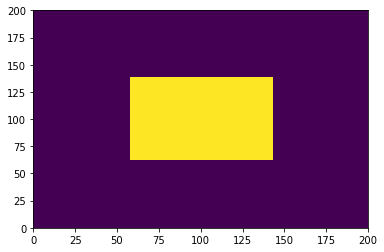

In [31]:
plt.pcolormesh(np.abs(sm.sample.obj_mask_full[...,50]))

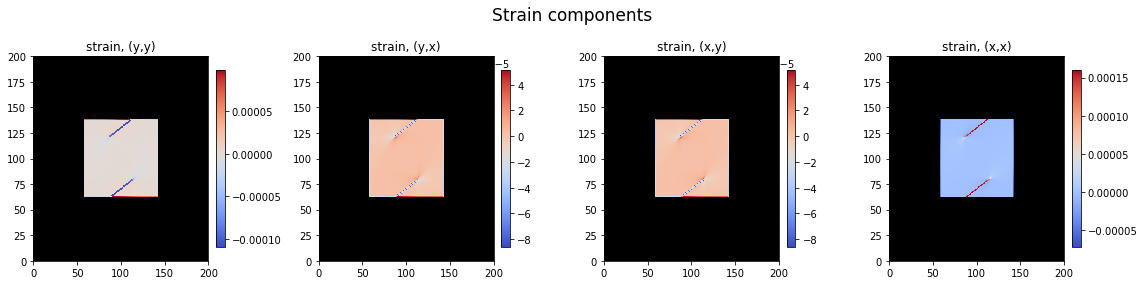

In [32]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j])
        s[i,j][plots_3d_mask] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        if i < 2 and j < 2:
            sl = s[i,j, :, :, 50]
            
        elif i < 2 and j ==2 :
            sl = s[i, j, :,:, 50]
        else:
            sl = s[i, j, :, :, 50]
        
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

if save_plots:
    plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

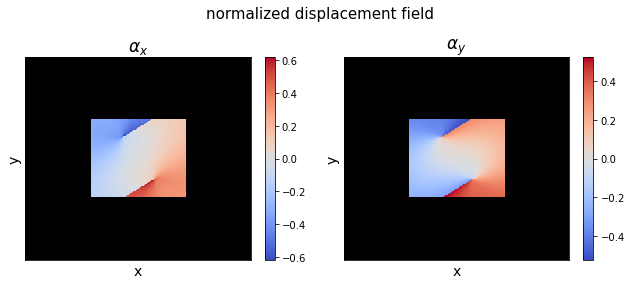

In [33]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
front = sm.sample.Ux_full / sm.sample.params.lattice[1]
front[plots_3d_mask] = np.nan
plt.pcolormesh(front[...,50], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-2, -1, 0, 1, 2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_x$', fontsize=17)

plt.subplot(1,2,2)
front = sm.sample.Uy_full / sm.sample.params.lattice[1]
front[plots_3d_mask] = np.nan
#cmap = mpl.cm.get_cmap('coolwarm')
#cmap.set_bad('black')
plt.pcolormesh(front[...,50], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-0.2, -0.1, 0, 0.1, 0.2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_y$', fontsize=17)
plt.suptitle("normalized displacement field", fontsize=15)
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/displacement.pdf', bbox_inches='tight')
plt.show()

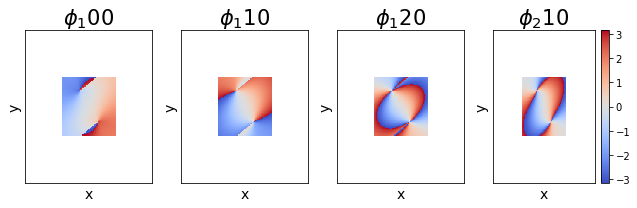

In [34]:
fig, axs = plt.subplots(1, 4, figsize=[9,3])

for i in range(4):
    front = np.angle(sm.sample.rhos[i])
    front[plots_3d_mask] = np.nan
    cax= axs[i].pcolormesh(front[...,50], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$\phi_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[3])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/phases.pdf', bbox_inches='tight')
plt.show()

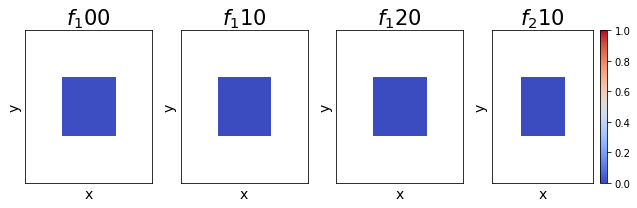

In [35]:
fig, axs = plt.subplots(1, 4, figsize=[9,3])

for i in range(4):
    front = np.abs(sm.rhos[i])
    front[plots_3d_mask] = np.nan
    cax= axs[i].pcolormesh(front[...,51], cmap='coolwarm', vmin=0, vmax=1.0)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$f_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[3])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/magnitudes.png', bbox_inches='tight')
plt.show()

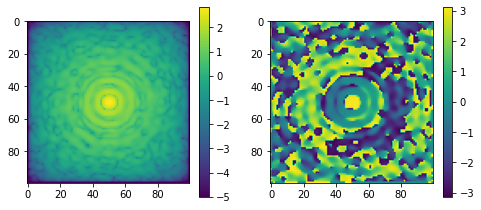

In [36]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d_hanning) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d_hanning))
plt.colorbar()
plt.show()

In [37]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

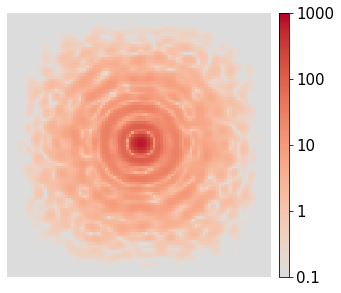

In [38]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)
    

probe_absvals = np.abs(probe_2d_hanning)
probe_angvals = np.angle(probe_2d_hanning)

probe_absvals[probe_absvals<0.1] = 0.1

new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)

#plt.sca(axes[0,0])
im = ax.pcolormesh(probe_absvals, cmap=new_cmap, norm=LogNorm(vmin=0.1, vmax=1000))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[0.1, 1, 10, 100, 1000])
cb.ax.set_yticklabels([0.1, 1, 10, 100, 1000])
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=15)

ax.set_aspect('equal')
ax.set_axis_off()
#ax.text(0.05, 1.02, '(' + string.ascii_lowercase[i] + ') ' + list(subplot_titles.values())[i],
#            transform=ax.transAxes, size=16)
plt.savefig('probe_mag.pdf', bbox_inches='tight')

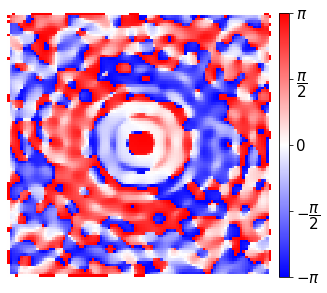

In [39]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)

probe_angvals[probe_absvals<0.1] = 0

im = ax.pcolormesh(probe_angvals, cmap='bwr',vmin=-np.pi, vmax=np.pi)
                          # norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.minorticks_off()
cb.ax.set_yticklabels([r'$-\pi$', r'$-\dfrac{\pi}{2}$', r'0',  r'$\dfrac{\pi}{2}$', r'$\pi$'])
cb.ax.tick_params(labelsize=15)

ax.set_axis_off()
ax.set_aspect('equal')

plt.savefig('probe_phase.pdf', bbox_inches='tight')